# 1. Setup and Load Data

### 1.1 Install Dependencies and Setup

In [5]:
!pip install tensorflow opencv-python matplotlib

In [6]:
import tensorflow as tf
import os

2025-04-04 01:02:12.279443: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
os.path.join('data', 'happy')

'data/happy'

In [8]:
# Avoid OOM(out of memory) error by setting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True) # keeping memory to a minimum

### 1.2 Remove Dodge Images

In [10]:
import cv2
import PIL  #allow us to check the file extensions for our images

In [11]:
data_dir = 'data'

In [12]:
os.listdir(data_dir)

['happy', '.DS_Store', 'sad']

In [13]:
image_exts = ['jpeg', 'jpg','bmp', 'png']

In [14]:
image_exts[3]

'png'

In [15]:
img = cv2.imread(os.path.join('data','happy','compassion.jpg'))

In [16]:
img.shape

(440, 1024, 3)

In [17]:
from matplotlib import pyplot as plt

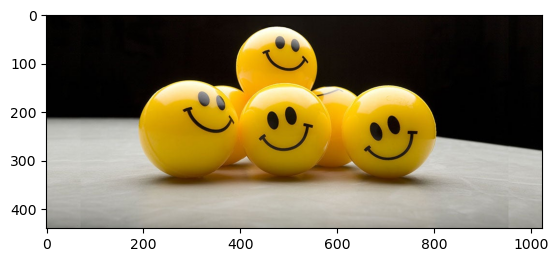

In [18]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [19]:
for image_class in os.listdir(data_dir):
    class_path = os.path.join(data_dir, image_class)
    # Skip if not a directory (e.g., .DS_Store)
    if not os.path.isdir(class_path):
        continue  # Skip non-directory files
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            # Use Pillow to check the image format
            with Image.open(image_path) as img:
                tip = img.format.lower()  # Get format (e.g., "jpeg", "png")
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

Issue with image data/happy/e162ccda8ce0f197f8863f327add9233.jpg
Issue with image data/happy/05-12-21-happy-people.jpg
Issue with image data/happy/Happy.jpg
Issue with image data/happy/if-you-recognize-these-signs-youre-a-naturally-happy-person.png
Issue with image data/happy/happy-and-peaceful-people.jpg
Issue with image data/happy/3-habits-happy-people-01.jpeg
Issue with image data/happy/7-principles-of-successful-and-happy-people.png
Issue with image data/happy/videoblocks-three-happy-people-posing-together-african-ethni.png
Issue with image data/happy/170404-happy-workers-feature.jpg
Issue with image data/happy/friends-happy-190821.jpg
Issue with image data/happy/p_2x_2e80cd363b64.png
Issue with image data/happy/eyJidWNrZXQiOiJvbS1wdWItc3RvcmFnZSIsImtleSI6ImFjdGl2ZWJlYXQv.webp
Issue with image data/happy/image-38.jpeg
Issue with image data/happy/happy-family-happy-people.jpg
Issue with image data/happy/file-20230208-27-3jttof.jpg
Issue with image data/happy/.DS_Store
Issue with ima

### 1.3 Load Data

In [21]:
# DATASET API -> we won' be using it directly here
tf.data.Dataset??

Init signature: tf.data.Dataset(variant_tensor)
Source:        
@tf_export("data.Dataset", v1=[])
class DatasetV2(
    collections_abc.Iterable,
    tracking_base.Trackable,
    composite_tensor.CompositeTensor,
    data_types.DatasetV2,
    metaclass=abc.ABCMeta):
  """Represents a potentially large set of elements.

  The `tf.data.Dataset` API supports writing descriptive and efficient input
  pipelines. `Dataset` usage follows a common pattern:

  1. Create a source dataset from your input data.
  2. Apply dataset transformations to preprocess the data.
  3. Iterate over the dataset and process the elements.

  Iteration happens in a streaming fashion, so the full dataset does not need to
  fit into memory.

  Source Datasets:

  The simplest way to create a dataset is to create it from a python `list`:

  >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
  >>> for element in dataset:
  ...   print(element)
  tf.Tensor(1, shape=(), dtype=int32)
  tf.Tensor(2, shape=(), dty

In [22]:
import numpy as np

In [247]:
# building the daa pipeline
data = tf.keras.utils.image_dataset_from_directory('data')

Found 180 files belonging to 2 classes.


In [24]:
# this is acually accessing the data pipeline itself, this is allowing us to loop through it
data_iterator = data.as_numpy_iterator()

In [25]:
# this is grabbing one batch back 
batch = data_iterator.next()

In [26]:
len(batch) # there are two batches, i.e. there are images and there are labels

2

In [27]:
# Images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

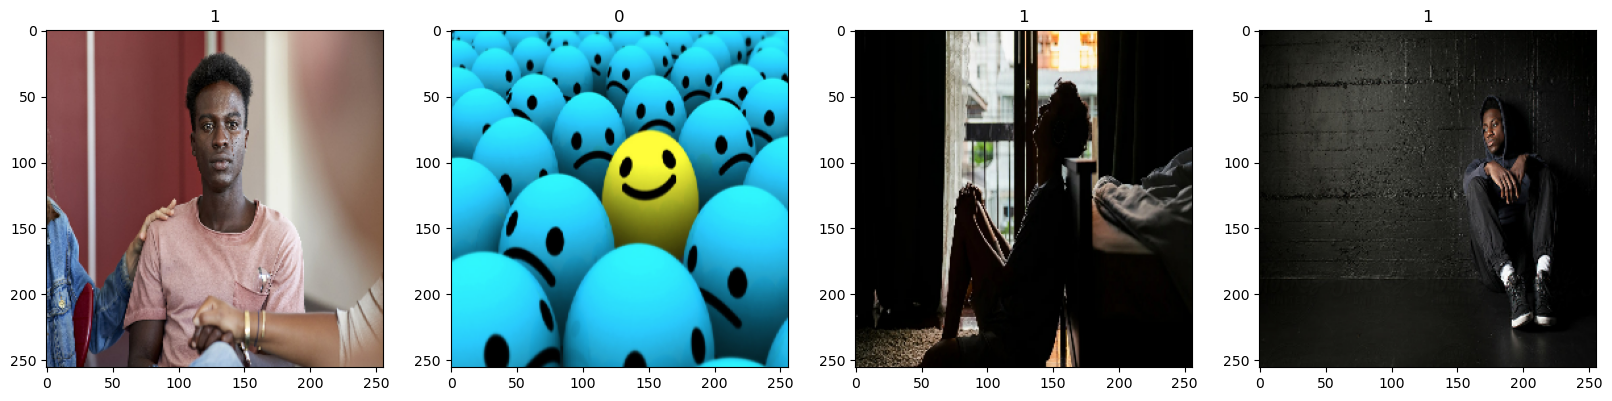

In [28]:
# lets see which label(0 or 1) is assigned to which class (happy or sad)
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
# class 1 -> sad, class 0 -> happy

# 2. Preprocess the Data

### 2.1 Scale Data

In [249]:
# inside the data pipeline, we will be using the map function, which allows us to apply a 
# particular type of transformation as our data is being preprocessed through the data pipelin
# i.e when we pre-fetch data, it's going to do that transformation, means it speeds up how 
# quickly we can access our data from our disk
data = data.map(lambda x,y: (x/255, y))

In [251]:
scaled_iterator = data.as_numpy_iterator()

In [259]:
batch = scaled_iterator.next()

In [255]:
batch[0].max()

1.0

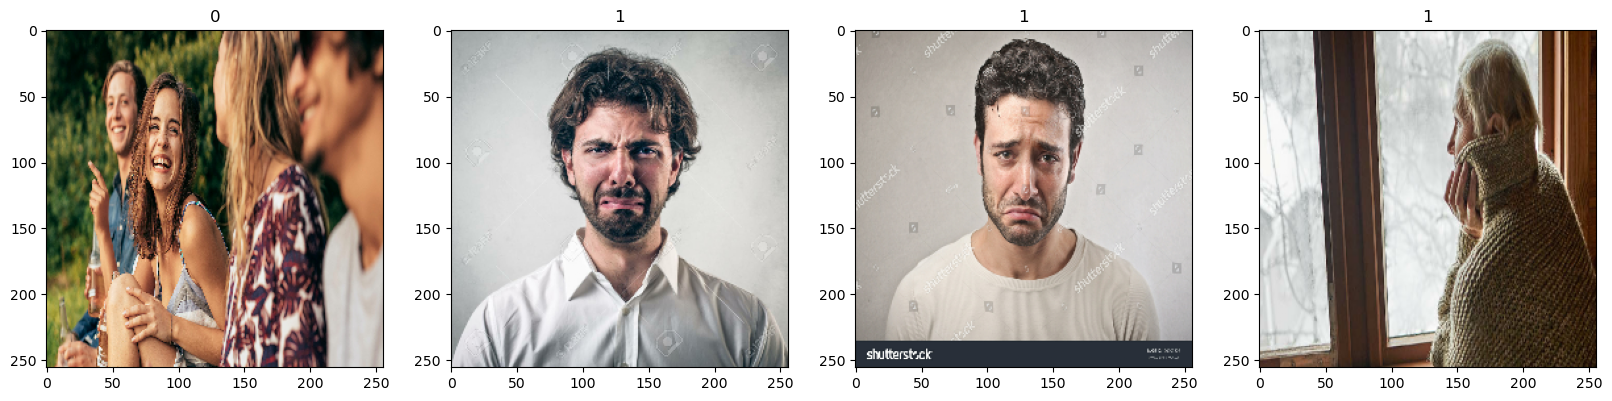

In [261]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

### 2.2 Split Data

In [37]:
len(data) #6 batches with each batch having 32 images

6

In [38]:
train_size = int(len(data)*.6)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [39]:
train_size + val_size + test_size

6

In [40]:
# using skip and take to decide particular partition for data we will use
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [41]:
len(val)

2

# 3. Deep Model

### 3.1 Build Deep Learning Model

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input

In [45]:
model = Sequential()

In [46]:
# adding layers sequentially
# Add the Input layer as the first layer
model.add(Input(shape=(256, 256, 3)))
# conv layer having 16 filters, 3 by 3 pixels in size, having a stride of 1 
model.add(Conv2D(16, (3,3), strides=(1,1), activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), strides=(1,1), activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), strides=(1,1), activation='relu'))
model.add(MaxPooling2D())

# to make it into a single vector 
model.add(Flatten()) 

# Fully Connected layers
# we got 256 neurons and again applying relu activations here
model.add(Dense(256, activation='relu'))
# final layer is a single dense layer, i.e. we'll get single output (0 or 1 because of 
# sigmoid activation function)
model.add(Dense(1, activation='sigmoid'))

In [47]:
#compile the model using adam optimizer
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [48]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

### 3.2 Train

In [50]:
logdir='logs'

In [51]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [263]:
# fitting our model and also validating it to see it's performance
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9583 - loss: 0.1330 - val_accuracy: 0.9375 - val_loss: 0.1903
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9740 - loss: 0.1194 - val_accuracy: 1.0000 - val_loss: 0.0602
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9427 - loss: 0.1595 - val_accuracy: 0.9688 - val_loss: 0.0828
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9688 - loss: 0.0785 - val_accuracy: 1.0000 - val_loss: 0.0421
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9818 - loss: 0.0780 - val_accuracy: 1.0000 - val_loss: 0.0321
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9518 - loss: 0.0800 - val_accuracy: 0.9688 - val_loss: 0.0870
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9570 - loss: 0.1030 - val_accuracy: 0.9844 - val_loss: 0.0402
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9466 - loss: 0.1160 - val_accuracy: 0.9688 - val_loss: 0.0536
Epoch 9/20
3/3 ━

In [265]:
hist.history

{'accuracy': [0.9479166865348816,
  0.9791666865348816,
  0.9479166865348816,
  0.96875,
  0.9791666865348816,
  0.9583333134651184,
  0.96875,
  0.9479166865348816,
  0.9895833134651184,
  0.96875,
  0.9791666865348816,
  0.9791666865348816,
  0.9791666865348816,
  0.9895833134651184,
  0.9895833134651184,
  0.9791666865348816,
  0.9791666865348816,
  0.9791666865348816,
  0.96875,
  0.9791666865348816],
 'loss': [0.16279549896717072,
  0.10235365480184555,
  0.16785413026809692,
  0.08158216625452042,
  0.08019456267356873,
  0.07332181930541992,
  0.0868612751364708,
  0.12128611654043198,
  0.05426338315010071,
  0.0741245299577713,
  0.057389307767152786,
  0.06606411188840866,
  0.04419046267867088,
  0.059546370059251785,
  0.046911220997571945,
  0.0372425802052021,
  0.035398852080106735,
  0.06473884731531143,
  0.09336169809103012,
  0.0484171062707901],
 'val_accuracy': [0.9375,
  1.0,
  0.96875,
  1.0,
  1.0,
  0.96875,
  0.984375,
  0.96875,
  0.984375,
  0.953125,
  0.98

### 3.3 Plot Performance

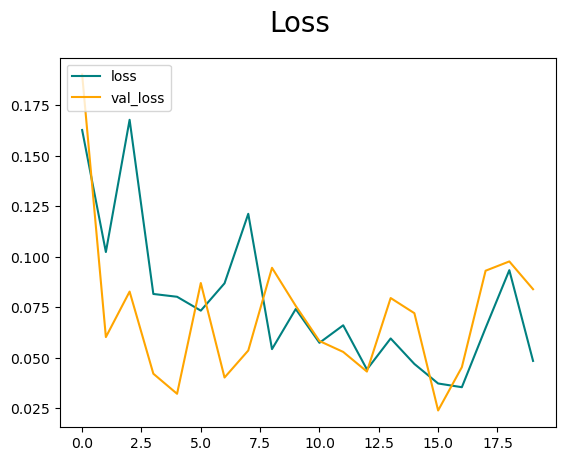

In [267]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

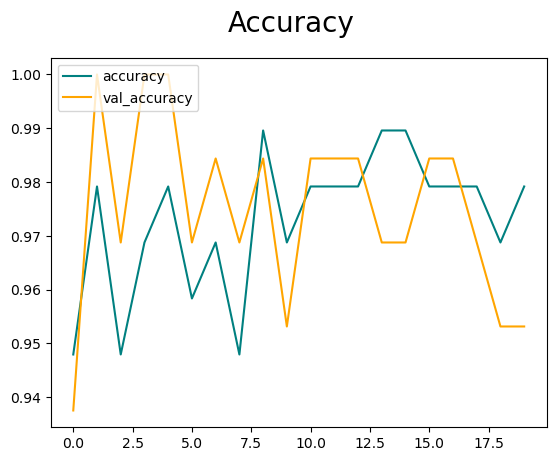

In [269]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 4. Evaluate Performance

### 4.1 Evaluate 

In [59]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [60]:
pre = Precision()
rec = Recall()
acc = BinaryAccuracy()

In [271]:
if len(test) == 1:
    X, y = next(test.as_numpy_iterator())
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    acc.update_state(y, yhat)
else:
    for batch in test.as_numpy_iterator():
        X, y = batch
        yhat = model.predict(X)
        pre.update_state(y, yhat)
        rec.update_state(y, yhat)
        acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


In [273]:
print(f'Precision:{pre.result().numpy()}, Recall:{rec.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.9473684430122375, Recall:1.0, Accuracy:0.9750000238418579


### 4.2 Test

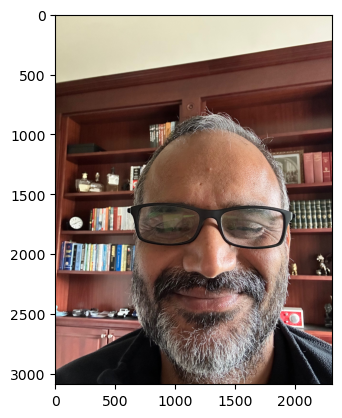

In [275]:
img = cv2.imread('thap.jpeg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

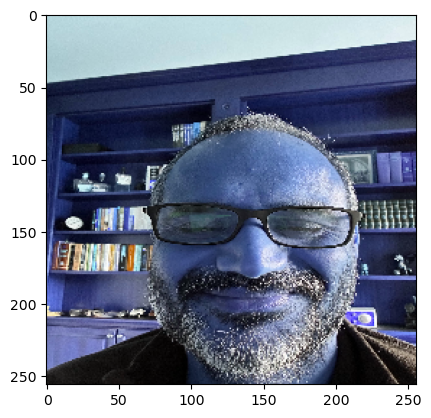

In [277]:
# to pass tthrough our DNN, we need the sam image sizes
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [279]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


In [281]:
yhat

array([[0.5579915]], dtype=float32)

In [283]:
if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


# 5 Save the model

In [137]:
from tensorflow.keras.models import load_model

In [139]:
model.save(os.path.join('models','imageclassifierversion.h5'))

In [165]:
new_model = load_model(os.path.join('models','imageclassifierversion.h5'))

In [167]:
new_model

<Sequential name=sequential, built=True>

In [173]:
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


In [175]:
if yhatnew > 0.6:
    print(f'Prediction class is Sad')
else:
    print(f'Prediction class is Happy')

Prediction class is Happy
